In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

# append parent directory to path (../notebooks -> ..)
sys.path.append(os.path.dirname(os.getcwd()))
os.chdir(os.path.dirname(os.getcwd()))

import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from einops import rearrange

import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc_file("../matplotlibrc")

from ldns.utils.eval_utils import (
    get_temp_corr_summary,
    group_neurons_temp_corr,
)
from ldns.utils.plotting_utils import (
    cm2inch,
    plot_cross_corr_summary,
    get_group_colors,
)


In [2]:
data_path = "exp/stored_spike_samples/"
save_path = "exp/monkey_spike_history/"
os.makedirs(save_path, exist_ok=True)

# ------------------------- choose model -------------------------
model_name = "ldns"  # "lfads"
# ----------------------------------------------------------------

if model_name == "ldns":
    with open(data_path + "train_data_dict.pkl", "rb") as f:
        rec_dict_numpy_train = pickle.load(f)
elif model_name == "lfads":
    with open(data_path + "inferred_data_dict.pkl", "rb") as f:
        lfads_recons = pickle.load(f)
    with open(data_path + "lfads_samples.pkl", "rb") as f:
        lfads_samples = pickle.load(f)
    # bring into the same format as the ldns data
    rec_dict_numpy_train = {}
    rec_dict_numpy_train["gt_spikes"] = lfads_recons["gt_spikes"]
    rec_dict_numpy_train["ae_rates"] = lfads_recons["inferred_rates"]
    rec_dict_numpy_train["ae_latents"] = lfads_recons["inferred_factors"]
    rec_dict_numpy_train["diffusion_rates"] = lfads_samples["model_rates"]
    rec_dict_numpy_train["diffusion_latents"] = lfads_samples["model_latents"]


In [3]:
# core functions for spike history modeling and sampling


def extract_timewise_histories(spikes, rates, history_length):
    """Extract spike history and rates for each time step in the data.

    Args:
        spikes: Tensor of shape (num_trials, num_neurons, num_timesteps) containing spike counts
        rates: Tensor of shape (num_trials, num_neurons, num_timesteps) containing firing rates
        history_length: Number of previous time steps to use as history

    Returns:
        combine_flat: Tensor of shape (num_trials*num_timesteps, num_neurons, history_length+2) containing
            concatenated spike history, rates and offset for each neuron
        target_flat: Tensor of shape (num_trials*num_timesteps, num_neurons) containing target spikes
    """
    _num_trials, _num_neurons, num_timesteps = spikes.shape

    target_ls = []
    spike_history_ls = []
    rates_ls = []
    for i in range(history_length, num_timesteps):
        target_ls.append(spikes[:, :, [i]])
        spike_history_ls.append(spikes[:, :, i - history_length : i])
        rates_ls.append(rates[:, :, [i]])

    target = torch.stack(target_ls, dim=2)
    spike_history = torch.stack(spike_history_ls, dim=2)
    rates = torch.stack(rates_ls, dim=2)
    offset = torch.ones_like(rates)

    combine = torch.cat([spike_history, rates, offset], dim=3)
    target_flat = rearrange(target, "b n t d -> (b t d) n")
    combine_flat = rearrange(combine, "b n t d -> (b t) n d")

    return combine_flat, target_flat


class CombinedLogisiticRegression(nn.Module):
    """Combined logistic regression model for spike prediction.

    Args:
        num_regs: Number of neurons/regressors
        dim: Input dimension (history_length + 2)
        nonlin: Nonlinearity to use ('softplus', 'sigmoid', or 'exp')
    """

    def __init__(self, num_regs, dim, nonlin="softplus"):
        super(CombinedLogisiticRegression, self).__init__()
        self.linear = nn.Parameter(torch.randn(num_regs, dim))
        self.nonlin = F.softplus

    def forward(self, x):
        return self.nonlin(torch.sum(torch.mul(x, self.linear), dim=-1))


def sample_from_rates_zero_start(log_rates, model, history_length, max_spikes=3):
    """Sample spikes from rates using trained model with zero initial history.

    Args:
        log_rates: Log firing rates tensor of shape (num_trials, num_neurons, num_timesteps)
        model: Trained CombinedLogisticRegression model
        history_length: Number of previous timesteps to use as history
        max_spikes: Maximum number of spikes allowed per bin

    Returns:
        Sampled spike tensor of shape (num_trials, num_neurons, num_timesteps)
    """
    num_trials, num_neurons, num_timesteps = log_rates.shape
    spikes = torch.zeros(num_trials, num_neurons, num_timesteps + history_length)

    for i in range(history_length, num_timesteps + history_length):
        reg_input = torch.cat(
            [
                spikes[:, :, i - history_length : i],
                log_rates[:, :, [i - history_length]],
                torch.ones_like(log_rates[:, :, [i - history_length]]),
            ],
            dim=2,
        )
        with torch.no_grad():
            p = model.forward(reg_input)
        if max_spikes == 1:
            spikes[:, :, i] = torch.bernoulli(p)
        else:
            spikes[:, :, i] = torch.min(torch.poisson(p), torch.ones_like(p) * max_spikes)

    return spikes[:, :, history_length:]


# model parameters
num_neurons = 182
ts_length = 140
history_length = 20
max_spikes = 5

# prepare training data
train_spikes = torch.from_numpy(np.float32(rec_dict_numpy_train["gt_spikes"]))
train_spikes = torch.min(train_spikes, max_spikes * torch.ones_like(train_spikes))
test_spikes = torch.from_numpy(np.float32(rec_dict_numpy_train["gt_spikes"]))
test_spikes = torch.min(test_spikes, max_spikes * torch.ones_like(test_spikes))

# use autoencoder rates for training, diffusion rates for evaluation
train_log_rates = torch.from_numpy(np.log(np.float32(rec_dict_numpy_train["ae_rates"])))
test_log_rates = torch.from_numpy(np.log(np.float32(rec_dict_numpy_train["diffusion_rates"])))

# transpose to (trials, neurons, timesteps)
train_spikes = torch.transpose(train_spikes, 2, 1)
test_spikes = torch.transpose(test_spikes, 2, 1)
train_log_rates = torch.transpose(train_log_rates, 2, 1)
test_log_rates = torch.transpose(test_log_rates, 2, 1)

print(train_spikes.shape)
print(train_log_rates.shape)
print(test_spikes.shape)
print(test_log_rates.shape)


torch.Size([2008, 182, 140])
torch.Size([2008, 182, 140])
torch.Size([2008, 182, 140])
torch.Size([2008, 182, 140])


In [4]:
# extract training data with spike histories
X_train, y_train = extract_timewise_histories(train_spikes, train_log_rates, history_length)

# initialize model with input size = history length + bias + rate terms
model = CombinedLogisiticRegression(num_neurons, history_length + 2)

# define poisson negative log likelihood loss
criterion = nn.PoissonNLLLoss(log_input=False, full=True)

# initialize optimizer with learning rate and weight decay
# note: lr=0.1, weight_decay=0.01 gives good results for poisson
optimizer = optim.AdamW(model.parameters(), lr=0.1, weight_decay=0.01)

# move model and data to gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
X_train = X_train.to(device)
y_train = y_train.to(device)


In [5]:
# train model for 3000 epochs, storing losses for plotting
store_losses = []
for epoch in range(3000):
    model.train()
    optimizer.zero_grad()

    y_pred = model(X_train)
    loss = criterion(y_pred.squeeze(), y_train.float())

    if epoch % 100 == 0:
        print("Epoch {}: train loss: {}".format(epoch, loss.item()))
    store_losses.append(loss.item())
    loss.backward()
    optimizer.step()


Epoch 0: train loss: 2.0188992023468018
Epoch 100: train loss: 0.0838230699300766
Epoch 200: train loss: 0.08239946514368057
Epoch 300: train loss: 0.08219365775585175
Epoch 400: train loss: 0.08213771879673004
Epoch 500: train loss: 0.08210327476263046
Epoch 600: train loss: 0.0820770412683487
Epoch 700: train loss: 0.08205695450305939
Epoch 800: train loss: 0.08204136788845062
Epoch 900: train loss: 0.08202902227640152
Epoch 1000: train loss: 0.08201905339956284
Epoch 1100: train loss: 0.08201086521148682
Epoch 1200: train loss: 0.08200402557849884
Epoch 1300: train loss: 0.08199848979711533
Epoch 1400: train loss: 0.08199328929185867
Epoch 1500: train loss: 0.08198953419923782
Epoch 1600: train loss: 0.08198526501655579
Epoch 1700: train loss: 0.08198193460702896
Epoch 1800: train loss: 0.08197960257530212
Epoch 1900: train loss: 0.0819764956831932
Epoch 2000: train loss: 0.0819738581776619
Epoch 2100: train loss: 0.08197180926799774
Epoch 2200: train loss: 0.0819697305560112
Epoch 

In [6]:
# move model to cpu for sampling
model = model.cpu()

# generate spike samples using history-dependent model
hist_spikes = sample_from_rates_zero_start(
    test_log_rates,
    model,
    history_length,
    max_spikes=max_spikes,
)

# convert test spikes to numpy
test_spikes_numpy = test_spikes.numpy()

# generate poisson spike samples with rate capping
pois_spikes_numpy = torch.min(
    torch.poisson(torch.exp(test_log_rates)),
    torch.ones_like(test_log_rates) * max_spikes,
).numpy()

# convert history-dependent samples to numpy
hist_spikes_numpy = hist_spikes.numpy()

# print max spike counts to verify capping worked
print(np.max(test_spikes_numpy))
print(np.max(pois_spikes_numpy))
print(np.max(hist_spikes_numpy))

# transpose arrays to (batch, neuron, time) format for correlation analysis
test_spikes_numpy = test_spikes_numpy.transpose(0, 2, 1)
pois_spikes_numpy = pois_spikes_numpy.transpose(0, 2, 1)
hist_spikes_numpy = hist_spikes_numpy.transpose(0, 2, 1)

3.0
5.0
5.0


### Compute the auto and cross correlations (5 min run time)

In [7]:
# group neurons based on temporal correlations into 4 groups
groups = group_neurons_temp_corr(test_spikes_numpy.transpose(1, 0, 2), num_groups=4)

# compute cross and auto correlations for test data
cross_corr_groups_test, auto_corr_groups_test = get_temp_corr_summary(
    test_spikes_numpy.transpose(1, 0, 2),
    groups,
    nlags=30,
    mode="biased",
    batch_first=False,
)

# compute cross and auto correlations for poisson samples
cross_corr_groups_pois, auto_corr_groups_pois = get_temp_corr_summary(
    pois_spikes_numpy.transpose(1, 0, 2),
    groups,
    nlags=30,
    mode="biased",
    batch_first=False,
)

# compute cross and auto correlations for history-dependent samples
cross_corr_groups_hist, auto_corr_groups_hist = get_temp_corr_summary(
    hist_spikes_numpy.transpose(1, 0, 2),
    groups,
    nlags=30,
    mode="biased",
    batch_first=False,
)


In [8]:
def history_plot_cross_corr_summary(
    cross_corr_groups,
    binWidth=None,
    cmap="Reds",
    figsize=(6, 4),
    linestyle="-",
    ax_corr=None,
    labels="group",
    title="cross-corr",
    xlabel="lag",
    ms=2,
    lw=1.5,
):
    """Plot cross-correlation summary for multiple groups.

    Args:
        cross_corr_groups: List of cross-correlation arrays for each group
        binWidth: Width of time bins for x-axis scaling
        cmap: Colormap name for group colors
        figsize: Figure size in inches
        linestyle: Line style for plots
        ax_corr: Existing axes to plot on (creates new if None)
        labels: Prefix for group labels in legend
        title: Plot title
        xlabel: x-axis label
        ms: Marker size
        lw: Line width

    Returns:
        matplotlib axes object with plotted correlations
    """
    # get number of groups and corresponding colors
    num_groups = len(cross_corr_groups)
    g_colors = get_group_colors(num_groups, cmap)

    # create new axes if not provided
    if ax_corr is None:
        fig_corr, ax_corr = plt.subplots(figsize=figsize)
    ax_corr.set_title(title)

    # calculate x-axis ticks based on lags
    nlag = int((len(cross_corr_groups[0]) - 1) / 2)
    x_ticks = np.arange(-nlag, nlag + 1, 1)

    # scale x-ticks by bin width if provided
    if binWidth is not None:
        x_ticks = x_ticks * binWidth

    # plot correlation for each group
    for ind in range(num_groups):
        # set center lag to nan to avoid self-correlation spike
        cross_corr_groups[ind][nlag] = np.nan
        ax_corr.plot(
            x_ticks,
            cross_corr_groups[ind],
            linestyle,
            lw=lw,
            ms=ms,
            color=g_colors[num_groups - ind - 1],
            label=f"{labels} {ind + 1}",
            solid_capstyle="round",
        )
    ax_corr.set_xlabel(xlabel)

    return ax_corr


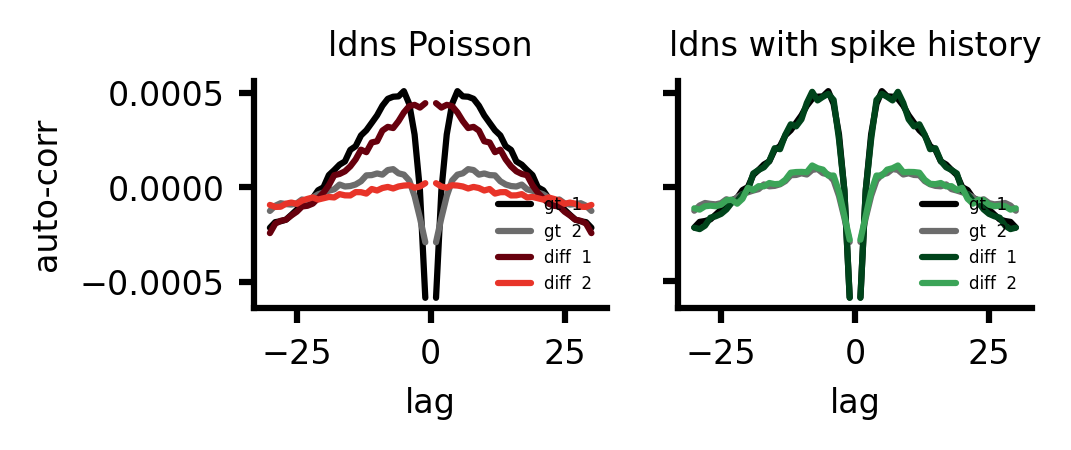

In [9]:
# plot autocorrelation comparison between ground truth, history-based and poisson models
fig, ax = plt.subplots(1, 2, figsize=cm2inch(8.5, 2.5))

# left subplot: ground truth vs poisson model
history_plot_cross_corr_summary(
    auto_corr_groups_test[:2],
    figsize=cm2inch(5, 3),
    cmap="Greys",
    ax_corr=ax[0],
    labels="gt ",
)
history_plot_cross_corr_summary(
    auto_corr_groups_pois[:2],
    figsize=cm2inch(5, 3),
    cmap="Reds" if model_name == "ldns" else "Purples",
    ax_corr=ax[0],
    labels="diff ",
    title=f"{model_name} Poisson",
)

# right subplot: ground truth vs history-based model
history_plot_cross_corr_summary(
    auto_corr_groups_test[:2],
    figsize=cm2inch(5, 3),
    cmap="Greys",
    ax_corr=ax[1],
    labels="gt ",
)
history_plot_cross_corr_summary(
    auto_corr_groups_hist[:2],
    figsize=cm2inch(5, 3),
    cmap="Greens" if model_name == "ldns" else "RdPu",
    ax_corr=ax[1],
    labels="diff ",
    title=f"{model_name} with spike history",
)

# format axes
ax[1].set_yticklabels([])
ax[0].set_ylabel("auto-corr")
ax[0].legend(fontsize=4, loc="lower right")
ax[1].legend(fontsize=4, loc="lower right")


In [10]:
# sample spikes multiple times from history-based model
history_spikes = []

# generate 5 different samples using the history-based model
for i in range(5):
    # sample spikes using history-based model
    hist_spikes = sample_from_rates_zero_start(
        test_log_rates,
        model,
        history_length,
        max_spikes=max_spikes,
    )

    # convert all spike arrays to numpy and transpose to (batch, time, neurons)
    test_spikes_numpy = test_spikes.numpy().transpose(0, 2, 1)
    hist_spikes_numpy = hist_spikes.numpy().transpose(0, 2, 1)
    pois_spikes_numpy = (
        torch.min(
            torch.poisson(torch.exp(test_log_rates)),
            torch.ones_like(test_log_rates) * max_spikes,
        )
        .numpy()
        .transpose(0, 2, 1)
    )

    history_spikes.append(hist_spikes_numpy)

# create dictionary with ground truth, poisson samples, rates and history samples
history_sampled_dict = {
    "gt": test_spikes_numpy,
    "pois": pois_spikes_numpy,
    "rate": torch.exp(test_log_rates).numpy().transpose(0, 2, 1),
    "hist": history_spikes,
}

# save results to pickle file
with open(data_path + f"history_sampled_dict_{model_name}_{max_spikes}.pkl", "wb") as f:
    pickle.dump(history_sampled_dict, f)


We can use these saved files in the comparisons notebook
